In [21]:
from random import random
import csv
import os
from functools import partial
import json

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D

from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    accept,
    constraints,
    updaters,
)
from gerrychain.metrics import efficiency_gap, mean_median, polsby_popper
from gerrychain.proposals import recom, flip
from gerrychain.updaters import cut_edges
from gerrychain.tree import recursive_tree_part, bipartition_tree

import tqdm

In [22]:
def pareto_driver(partition, metrics, p=0.01):
    """
    If the proposed partition dominates the previous partition
    with respect to a set of scalar metrics, we accept the proposal
    with probability 1.
    
    Otherwise, we accept the proposal with probability ``p``.
    """
    dominant = True
    for metric in metrics:
        if partition[metric] >= partition.parent[metric]:
            dominant = False
            break
    return dominant or random() < p

In [105]:
unique_label = "loc_prec"
pop_col = "TOTPOP"
district_col = "CD"

graph_path = "./VA_precincts/VA_precincts.shp"

In [106]:
jgraph = Graph.from_json("va_json.json")

In [107]:
df = gpd.read_file(graph_path)

def num_splits(partition):
    df["current"] = df[unique_label].map(dict(partition.assignment))
    splits = sum(df.groupby("precinct")["current"].nunique() > 1)
    return splits

In [151]:
def pop_dist_pct(partition):
    ideal_population = ideal_population = sum(partition["population"].values()) / len(
    partition)
    total_deviation = total_deviation = sum([abs(v - ideal_population) for v in partition['population'].values()])
    avg_dist = total_deviation/len(partition)
    return avg_dist/ideal_population

def abs_efficiency_gap(partition):
    return abs(efficiency_gap(partition["G18SEN"]))

my_updaters = {
    "cut_edges": cut_edges,
    "population": updaters.Tally("TOTPOP", alias = "population"),
    "pop_dist_pct" : pop_dist_pct,
    "area": updaters.Tally("Area", alias = "area"),
    "perimeter": updaters.Tally("Perimeter", alias = "perimeter"),
    "abs_efficiency_gap": abs_efficiency_gap
}

In [152]:
pareto = partial(pareto_driver, metrics=['cut_edges', 'abs_efficiency_gap'])

In [153]:
df["nBVAP"] = df["VAP"] - df["BVAP"]
df.round({"VAP": 1, "BVAP": 1, "nBVAP": 1})
df["G18DSEN"] = df["G18DSEN"].astype(float)
df["G18RSEN"] = df["G18RSEN"].astype(float)
df["G17DGOV"] = df["G17DGOV"].astype(float)
df["G17RGOV"] = df["G17RGOV"].astype(float)
df["G16DPRS"] = df["G16DPRS"].astype(float)
df["G16RPRS"] = df["G16RPRS"].astype(float)

In [154]:
num_elections = 4

election_names = [
    "G18SEN",
    "G17GOV",
    "G16PRS",
    "BVAPs"
]

election_columns = [
    [df["G18DSEN"], df["G18RSEN"]],
    [df["G17DGOV"], df["G17RGOV"]],
    [df["G16DPRS"], df["G16RPRS"]],
    [df["BVAP"], df["nBVAP"]],
]

elections = [
    Election(
        election_names[i],
        {"Democratic": election_columns[i][0], "Republican": election_columns[i][1]},
    )
    for i in range(num_elections)
]

election_updaters = {election.name: election for election in elections}

my_updaters.update(election_updaters)

In [155]:
num_dist = 100
initial_partition = Partition(jgraph, "HDIST_11", my_updaters)
pop = sum(initial_partition_temp["population"].values())
#random_plan = recursive_tree_part(jgraph, range(num_dist), pop/num_dist, "TOTPOP", 0.01, 5)
#initial_partition = Partition(jgraph, random_plan, my_updaters)

In [156]:
ideal_population = pop / len(initial_partition)

proposal = partial(
    flip, #pop_col="TOTPOP", pop_target=ideal_population, epsilon=0.1, node_repeats=5
)

In [157]:
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]), 2 * len(initial_partition["cut_edges"])
)

In [169]:
chain_length = 10000

chain = MarkovChain(
    proposal=proposal,
    constraints=[
        constraints.within_percent_of_ideal_population(initial_partition, .25),
        compactness_bound,  # single_flip_contiguous#no_more_discontiguous
    ],
    accept=pareto,
    initial_state=initial_partition,
    total_steps=chain_length,
)

pop_vec = []
cut_vec = []
mms_vec = []
egs_vec = []
pop_dist_vec = []
pop_pct_vec = []
splits = []
pol_pop = []
votes = [[],[],[],[]]

t=0

for part in chain.with_progress_bar():
    splits.append(num_splits(part))
    #pop_dist_vec.append(avg_pop_dist(part))
    pop_vec.append(sorted(list(part["population"].values())))
    cut_vec.append(len(part["cut_edges"]))
    mms_vec.append([])
    egs_vec.append([])
    pop_pct_vec.append(pop_dist_pct(part))
    pol_pop.append(polsby_popper(part))
    
    for elect in range(num_elections):
        votes[elect].append(sorted(part[election_names[elect]].percents("Democratic")))
        mms_vec[-1].append(mean_median(part[election_names[elect]]))
        egs_vec[-1].append(efficiency_gap(part[election_names[elect]]))

In [81]:
bvp_by_dist = []
for k in range(num_dist):
    bvp_by_dist.append([])
for i in range(chain_length):
    for j in range(num_dist):
        bvp_by_dist[j].append(votes[3][i][j])

Text(0.5, 1.0, 'Virginia House Districts by %BVAP')

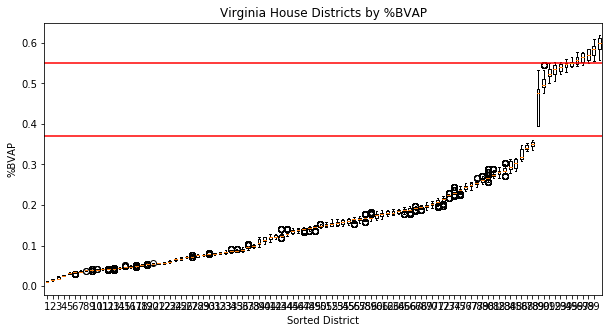

In [82]:
plt.figure(figsize = (10,5))
plt.boxplot(bvp_by_dist)
plt.axhline(0.37, color="red", label="37%")
plt.axhline(0.55, color = "red", label="55%")
plt.xticks(np.arange(1,100), [str(u) for u in range(1,101)])
plt.xlabel("Sorted District")
plt.ylabel("%BVAP")
plt.title("Virginia House Districts by %BVAP")

In [170]:
edges_vec = []
for i in range(chain_length):
    edges_vec.append(6859)
pct_ce = np.divide(cut_vec, edges_vec)

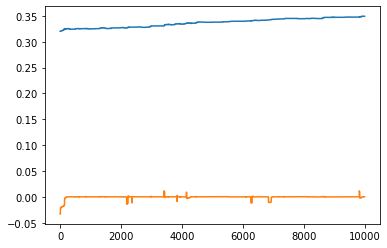

In [172]:
plt.plot(pct_ce)
plt.plot(egs_new)

In [93]:
edges_vec_a = []
for i in range(chain_length):
    edges_vec_a.append(6859)
pct_ce_a = np.divide(cut_vec, edges_vec)

(array([ 48.,  89.,  43., 106.,  62.,  88.,  97., 185.,  91., 191.]),
 array([0.32016329, 0.32686981, 0.33357632, 0.34028284, 0.34698936,
        0.35369587, 0.36040239, 0.36710891, 0.37381542, 0.38052194,
        0.38722846]),
 <a list of 10 Patch objects>)

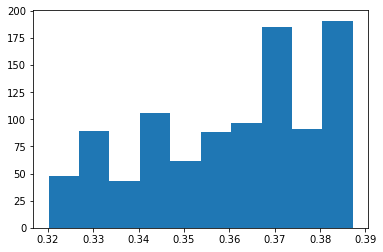

In [95]:
plt.hist(pct_ce_a)

In [134]:
initial_partition["efficiency_gap_sen18"]

TypeError: 'numpy.float64' object is not callable

In [171]:
egs_new = []
for i in range(chain_length):
    egs_new.append(egs_vec[i][0])

In [168]:
egs_new

[-0.033032620022596146,
 -0.033032620022596146,
 -0.033032620022596146,
 -0.033032620022596146,
 -0.033032620022596146,
 -0.033032620022596146,
 -0.033032620022596146,
 -0.033032620022596146,
 -0.033032620022596146,
 -0.033032620022596146,
 -0.033032620022596146,
 -0.033032620022596146,
 -0.033032620022596146,
 -0.033032620022596146,
 -0.033032620022596146,
 -0.033032620022596146,
 -0.033032620022596146,
 -0.03228266441984598,
 -0.03228266441984598,
 -0.020325106667629243,
 -0.020325106667629243,
 -0.01971801425646715,
 -0.01971801425646715,
 -0.01971801425646715,
 -0.01971801425646715,
 -0.01971801425646715,
 -0.01971801425646715,
 -0.01971801425646715,
 -0.01971801425646715,
 -0.019403349700154834,
 -0.019403349700154834,
 -0.019403349700154834,
 -0.019403349700154834,
 -0.008033084556428066,
 -0.008033084556428066,
 -0.008033084556428066,
 -0.008033084556428066,
 -0.008033084556428066,
 -0.008033084556428066,
 -0.008033084556428066,
 -0.008033084556428066,
 -0.008033084556428066,
 -